In [55]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import matplotlib.pyplot as plt

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 4 # Options are [1, 2, 3, 4]
test_type = 'attack_type' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()


,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.headers.Location,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,de-CH,none,same-origin,no-store,?1,document,['ck=FJRAiycx_3ekqPVGrPhoLGnQ_MKj1ittQ-MCq2zXC...,"Sun, 18 Dec 2022 01:27:48 GMT",GET,http://127.0.0.1:5000/forum?message=%3C%2Fh2%3...,,XSS,302 FOUND,text/html; charset=utf-8,199,/forum,302,text/html; charset=utf-8,NaN,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,"en-US,en;q=0.5",none,websocket,no-store,?1,document,['cid=y03gw4TI3ch-xC1BinML6NAIN0DQNEwmnuyTkVoL...,"Sun, 18 Dec 2022 01:36:14 GMT",GET,http://127.0.0.1:5000/greet/Capito,,NaN,200 OK,text/html; charset=utf-8,22,NaN,200,text/html; charset=utf-8,"""Windows""",NaN,NaN,NaN,NaN
2,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GET,http://127.0.0.1:5000/bookstore,,NaN,200 OK,application/json,41,NaN,200,"{""message"": ""Welcome to the Book Store!""}",NaN,NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko...,"gzip, deflate, br",*/*,keep-alive,?0,de,none,websocket,max-age=0,?1,document,['ck=dratLqJCNUT6dOw-tyeIHFWXCwmuoWbNq9b70hwkv...,"Sun, 18 Dec 2022 01:30:29 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,Log Forging,401 UNAUTHORIZED,application/json,41,NaN,401,"{""error"": ""Not a number failed to parse""}",NaN,NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,de-CH,none,websocket,max-age=0,?1,document,['cid=iBjOK5E1jqEbufkmhwMyCqp-6teXdsEeLrZLl3Ub...,"Sun, 18 Dec 2022 01:41:45 GMT",POST,http://127.0.0.1:5000/categories/check/all?id=...,MkdXwyHaWCdnLhoXJDzY,NaN,200 OK,application/json,871,NaN,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...","""Windows""",20,NaN,NaN,NaN


# Basic dataset label arrangements

In [56]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.headers.Location,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,de-CH,none,same-origin,no-store,?1,document,['ck=FJRAiycx_3ekqPVGrPhoLGnQ_MKj1ittQ-MCq2zXC...,"Sun, 18 Dec 2022 01:27:48 GMT",GET,http://127.0.0.1:5000/forum?message=%3C%2Fh2%3...,,302 FOUND,text/html; charset=utf-8,199,/forum,302,text/html; charset=utf-8,NaN,NaN,NaN,NaN,NaN,XSS,Malware
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,"en-US,en;q=0.5",none,websocket,no-store,?1,document,['cid=y03gw4TI3ch-xC1BinML6NAIN0DQNEwmnuyTkVoL...,"Sun, 18 Dec 2022 01:36:14 GMT",GET,http://127.0.0.1:5000/greet/Capito,,200 OK,text/html; charset=utf-8,22,NaN,200,text/html; charset=utf-8,"""Windows""",NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GET,http://127.0.0.1:5000/bookstore,,200 OK,application/json,41,NaN,200,"{""message"": ""Welcome to the Book Store!""}",NaN,NaN,NaN,NaN,NaN,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko...,"gzip, deflate, br",*/*,keep-alive,?0,de,none,websocket,max-age=0,?1,document,['ck=dratLqJCNUT6dOw-tyeIHFWXCwmuoWbNq9b70hwkv...,"Sun, 18 Dec 2022 01:30:29 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,401 UNAUTHORIZED,application/json,41,NaN,401,"{""error"": ""Not a number failed to parse""}",NaN,NaN,NaN,NaN,NaN,Log Forging,Malware
4,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,de-CH,none,websocket,max-age=0,?1,document,['cid=iBjOK5E1jqEbufkmhwMyCqp-6teXdsEeLrZLl3Ub...,"Sun, 18 Dec 2022 01:41:45 GMT",POST,http://127.0.0.1:5000/categories/check/all?id=...,MkdXwyHaWCdnLhoXJDzY,200 OK,application/json,871,NaN,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...","""Windows""",20,NaN,NaN,NaN,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182762,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,"en-US,en;q=0.5",none,same-origin,max-age=0,?1,document,['ttauth=vDA_pRaPgv5BX9UlIvE2-G5JEBJe4PvEXroOv...,"Sun, 18 Dec 2022 01:37:37 GMT",GET,http://127.0.0.1:5000/categories/check/name/Pr...,,200 OK,application/json,101,NaN,200,"{""category_id"": ""7"", ""category_name"": ""Produce...","""Windows""",NaN,NaN,NaN,NaN,Benign,Benign
182763,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,?1,de-CH,none,same-origin,no-cache,?1,document,['cid=YQAQXREK77h1CZXs6lAoKHvBgZfKuaV4aEMuONaI...,"Sun, 18 Dec 2022 01:20:52 GMT",GET,http://127.0.0.1:5000/login/user?username=Sowi...,,401 UNAUTHORIZED,application/json,26,NaN,401,"{""error"": ""Access denied""}","""Windows""",NaN,NaN,NaN,NaN,Benign,Benign
182764,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,max-age=0,?1,document,['ck=Y0mqGJ92oxXkiQMuhlP3oypr6p0wBFCvveiuxxe-R...,"Sun, 18 Dec 2022 01:22:10 GMT",GET,http://127.0.0.1:5000/forum?message=%3C%2Fp%3E...,,302 FOUND,text/html; c

In [57]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.headers.Location,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,de-CH,none,same-origin,no-store,?1,document,['ck=FJRAiycx_3ekqPVGrPhoLGnQ_MKj1ittQ-MCq2zXC...,"Sun, 18 Dec 2022 01:27:48 GMT",GET,http://127.0.0.1:5000/forum?message=%3C%2Fh2%3...,,302 FOUND,text/html; charset=utf-8,199,/forum,302,text/html; charset=utf-8,None,None,None,None,None,XSS,Malware
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?0,"en-US,en;q=0.5",none,websocket,no-store,?1,document,['cid=y03gw4TI3ch-xC1BinML6NAIN0DQNEwmnuyTkVoL...,"Sun, 18 Dec 2022 01:36:14 GMT",GET,http://127.0.0.1:5000/greet/Capito,,200 OK,text/html; charset=utf-8,22,None,200,text/html; charset=utf-8,"""Windows""",None,None,None,None,Benign,Benign
2,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,None,None,None,None,None,None,None,None,None,GET,http://127.0.0.1:5000/bookstore,,200 OK,application/json,41,None,200,"{""message"": ""Welcome to the Book Store!""}",None,None,None,None,None,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko...,"gzip, deflate, br",*/*,keep-alive,?0,de,none,websocket,max-age=0,?1,document,['ck=dratLqJCNUT6dOw-tyeIHFWXCwmuoWbNq9b70hwkv...,"Sun, 18 Dec 2022 01:30:29 GMT",GET,http://127.0.0.1:5000/orders/check/exists?val=...,,401 UNAUTHORIZED,application/json,41,None,401,"{""error"": ""Not a number failed to parse""}",None,None,None,None,None,Log Forging,Malware
4,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,de-CH,none,websocket,max-age=0,?1,document,['cid=iBjOK5E1jqEbufkmhwMyCqp-6teXdsEeLrZLl3Ub...,"Sun, 18 Dec 2022 01:41:45 GMT",POST,http://127.0.0.1:5000/categories/check/all?id=...,MkdXwyHaWCdnLhoXJDzY,200 OK,application/json,871,None,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...","""Windows""",20,None,None,None,Benign,Benign


In [58]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                'request.headers.Connection',
                'request.headers.Host',
                'request.headers.Accept',
                'request.method',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-Dest',
                'request.headers.Sec-Fetch-User',
                'response.status',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                    'request.headers.Set-Cookie',
                    'request.headers.Date',
                    'request.url',
                    'response.headers.Content-Type',
                    'response.body',
                    'response.headers.Location',
                    'request.headers.Content-Length',
                    'request.headers.Cookie',
                    'response.headers.Set-Cookie',
                    'request.headers.Upgrade-Insecure-Requests',
                    'request.headers.Sec-Ch-Ua-Mobile',
                    'request.headers.Cache-Control',
                    'request.headers.Sec-Ch-Ua-Platform'
                    ]

COLUMNS_TO_REMOVE = ['request.body',
                    'response.headers.Content-Length',
                    'request.headers.Date']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=3)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.headers.Location,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests,attack_type,label
0,0,0.000000,1,0,0,0.0,2,1,1,0.0,0,1,0.808290,0,0.218218,2,-0.408248,0.0,302,-0.408248,0.0,0.0,0.0,0.0,0.0,XSS,Malware
1,0,0.182574,1,0,0,0.0,3,1,2,0.0,0,1,0.428571,0,0.000000,0,-0.408248,0.0,200,-0.408248,0.0,0.0,0.0,0.0,0.0,Benign,Benign
2,0,0.000000,0,0,0,0.0,0,0,0,0.0,1,0,0.000000,0,0.707107,0,0.000000,0.0,200,-0.707107,0.0,0.0,0.0,0.0,0.0,Benign,Benign
3,0,0.000000,1,0,0,0.0,1,1,2,0.0,0,1,0.598671,0,0.447214,4,0.000000,0.0,401,0.408248,0.0,0.0,0.0,0.0,0.0,Log Forging,Malware
4,0,0.707107,631,0,0,0.0,2,1,2,0.0,0,1,0.660827,1,-1.000000,0,0.000000,0.0,200,-0.872872,0.0,0.0,0.0,0.0,0.0,Benign,Benign


In [59]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182767 entries, 0 to 182766
Data columns (total 27 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   request.headers.Host                       182767 non-null  int32  
 1   request.headers.User-Agent                 182767 non-null  float64
 2   request.headers.Accept-Encoding            182767 non-null  int32  
 3   request.headers.Accept                     182767 non-null  int32  
 4   request.headers.Connection                 182767 non-null  int32  
 5   request.headers.Sec-Ch-Ua-Mobile           182767 non-null  float64
 6   request.headers.Accept-Language            182767 non-null  int32  
 7   request.headers.Sec-Fetch-Site             182767 non-null  int32  
 8   request.headers.Sec-Fetch-Mode             182767 non-null  int32  
 9   request.headers.Cache-Control              182767 non-null  float64
 10  request.

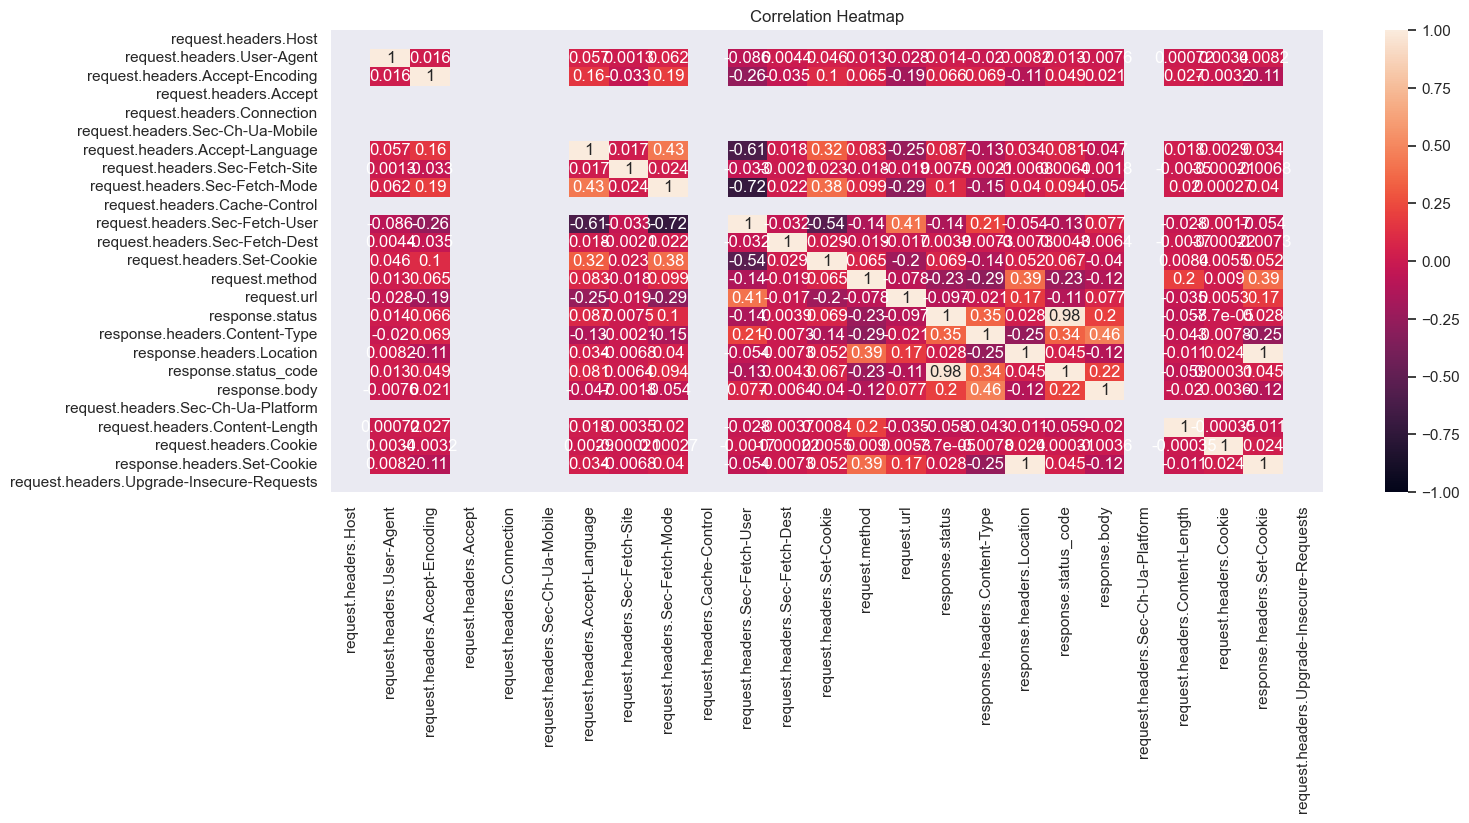

In [60]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});


# Check which fields don't matter

# Drop unnecessary fields

In [61]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.Host', 'request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept', 'request.headers.Connection', 'request.headers.Sec-Ch-Ua-Mobile', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Cache-Control', 'request.headers.Sec-Fetch-User', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Type', 'response.headers.Location', 'response.status_code', 'response.body', 'request.headers.Sec-Ch-Ua-Platform', 'request.headers.Content-Length', 'request.headers.Cookie', 'response.headers.Set-Cookie', 'request.headers.Upgrade-Insecure-Requests']


request.headers.Host                           int32
request.headers.User-Agent                   float64
request.headers.Accept-Encoding                int32
request.headers.Accept                         int32
request.headers.Connection                     int32
request.headers.Sec-Ch-Ua-Mobile             float64
request.headers.Accept-Language                int32
request.headers.Sec-Fetch-Site                 int32
request.headers.Sec-Fetch-Mode                 int32
request.headers.Cache-Control                float64
request.headers.Sec-Fetch-User                 int32
request.headers.Sec-Fetch-Dest                 int32
request.headers.Set-Cookie                   float64
request.method                                 int32
request.url                                  float64
response.status                                int32
response.headers.Content-Type                float64
response.headers.Location                    float64
response.status_code                          

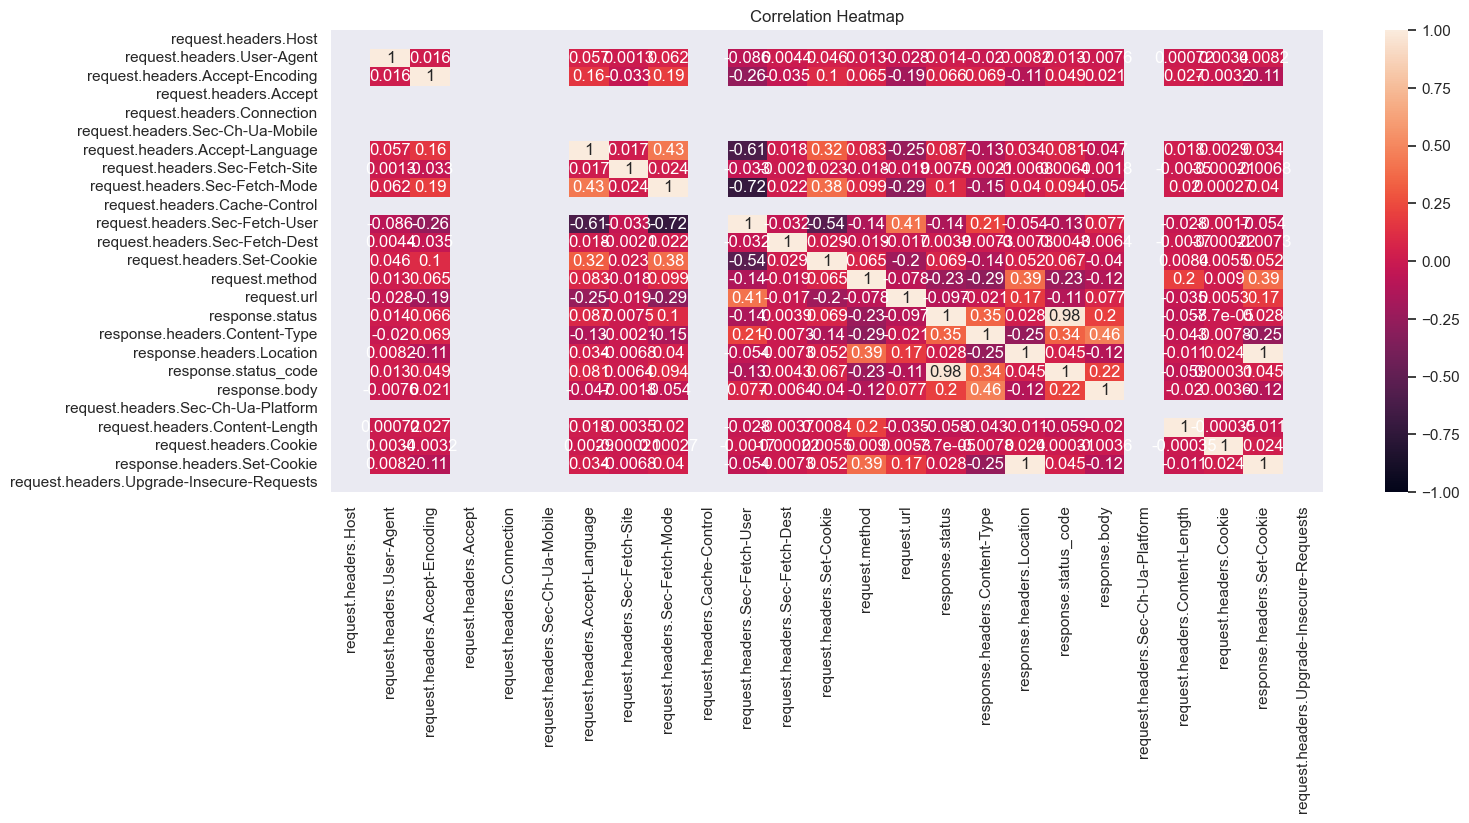

In [62]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});


# Train test split

In [63]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(150508, 25) (150508,)
(32259, 25) (32259,)


Counter({'XSS': 8017,
         'Benign': 143431,
         'Log Forging': 4037,
         'LOG4J': 3733,
         'SQL Injection': 7924,
         'RCE': 3944,
         'Cookie Injection': 7742,
         'Directory Traversal': 3939})

# Model choosing and fitting

## Random Forest

In [70]:
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.datasets import make_classification
# from sklearn.utils import shuffle
# x, y1 = make_classification(n_informative= 10, n_classes=8,
#                             random_state=1)
# y2 = shuffle(y1, random_state=1)
# y3 = shuffle(y1, random_state=2)
# Y = np.vstack((y1, y2, y3)).T
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=150)
# multi_target_forest = MultiOutputClassifier(clf, n_jobs=2)
# Train Model
# multi_target_forest.fit(x, Y)
clf.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 118115), ('Cookie Injection', 6376), ('Directory Traversal', 3244), ('LOG4J', 3074), ('Log Forging', 3324), ('RCE', 3248), ('SQL Injection', 6525), ('XSS', 6602)]


                     precision    recall  f1-score   support

             Benign    0.95862   0.95995   0.95928     25316
   Cookie Injection    0.97837   0.99341   0.98583      1366
Directory Traversal    0.93914   0.97698   0.95769       695
              LOG4J    0.79327   0.50076   0.61395       659
        Log Forging    0.73913   0.85835   0.79429       713
                RCE    0.95205   0.99856   0.97475       696
      SQL Injection    0.76238   0.77055   0.76644      1399
                XSS    0.76454   0.76184   0.76319      1415

           accuracy                        0.93403     32259
          macro avg    0.86094   0.85255   0.85193     32259
       weighted avg    0.93364   0.93403   0.93304     32259



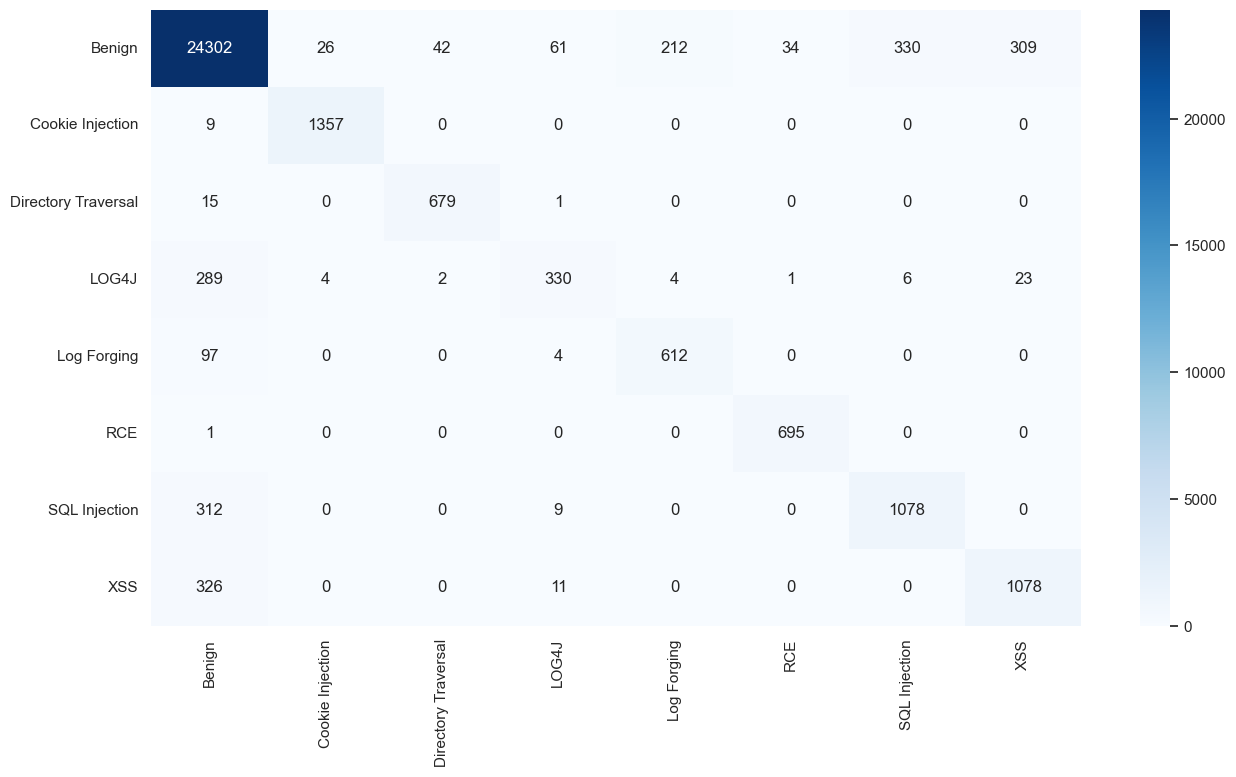

In [71]:
# We print our results
# x_test_multi= make_classification(n_informative= 10, n_classes=8,
#                             random_state=1)
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

## Naive Bayes

In [72]:
from sklearn.naive_bayes import GaussianNB
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import make_pipeline
# nBase = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=1))
nBase = GaussianNB()
nBase.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 118115), ('Cookie Injection', 6376), ('Directory Traversal', 3244), ('LOG4J', 3074), ('Log Forging', 3324), ('RCE', 3248), ('SQL Injection', 6525), ('XSS', 6602)]


                     precision    recall  f1-score   support

             Benign    0.99391   0.65160   0.78715     25316
   Cookie Injection    0.96371   0.66105   0.78419      1366
Directory Traversal    0.38287   0.99712   0.55329       695
              LOG4J    0.97309   0.32929   0.49206       659
        Log Forging    0.70020   0.99579   0.82224       713
                RCE    0.24690   1.00000   0.39602       696
      SQL Injection    0.14256   0.77627   0.24088      1399
                XSS    0.56648   0.49682   0.52937      1415

           accuracy                        0.66660     32259
          macro avg    0.62122   0.73849   0.57565     32259
       weighted avg    0.90077   0.66660   0.73330     32259



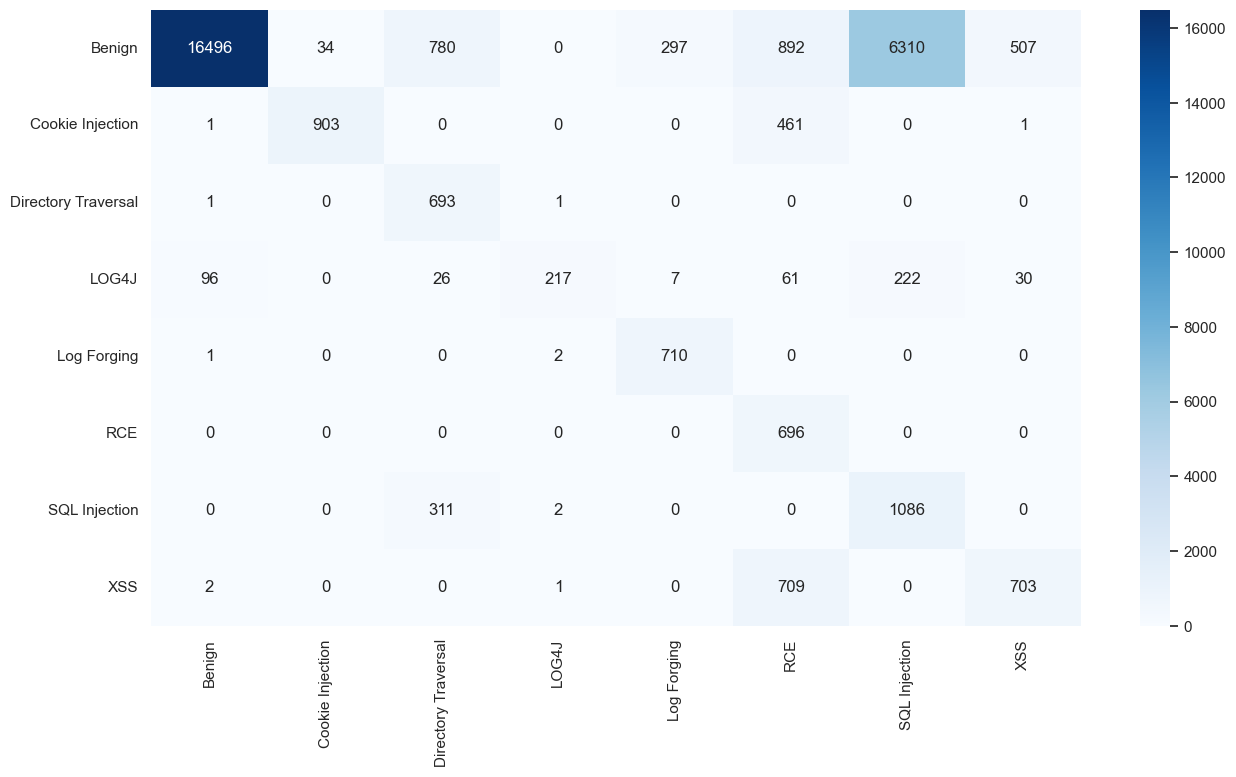

In [73]:

# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = nBase.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## KNN

In [80]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 118115), ('Cookie Injection', 6376), ('Directory Traversal', 3244), ('LOG4J', 3074), ('Log Forging', 3324), ('RCE', 3248), ('SQL Injection', 6525), ('XSS', 6602)]


                     precision    recall  f1-score   support

             Benign    0.94286   0.94976   0.94630     25316
   Cookie Injection    0.94248   0.99561   0.96832      1366
Directory Traversal    0.82219   0.83165   0.82690       695
              LOG4J    0.95402   0.50379   0.65938       659
        Log Forging    0.72338   0.87658   0.79264       713
                RCE    0.81576   0.92241   0.86581       696
      SQL Injection    0.65391   0.57398   0.61134      1399
                XSS    0.76895   0.75265   0.76071      1415

           accuracy                        0.91289     32259
          macro avg    0.82794   0.80080   0.80393     32259
       weighted avg    0.91272   0.91289   0.91100     32259



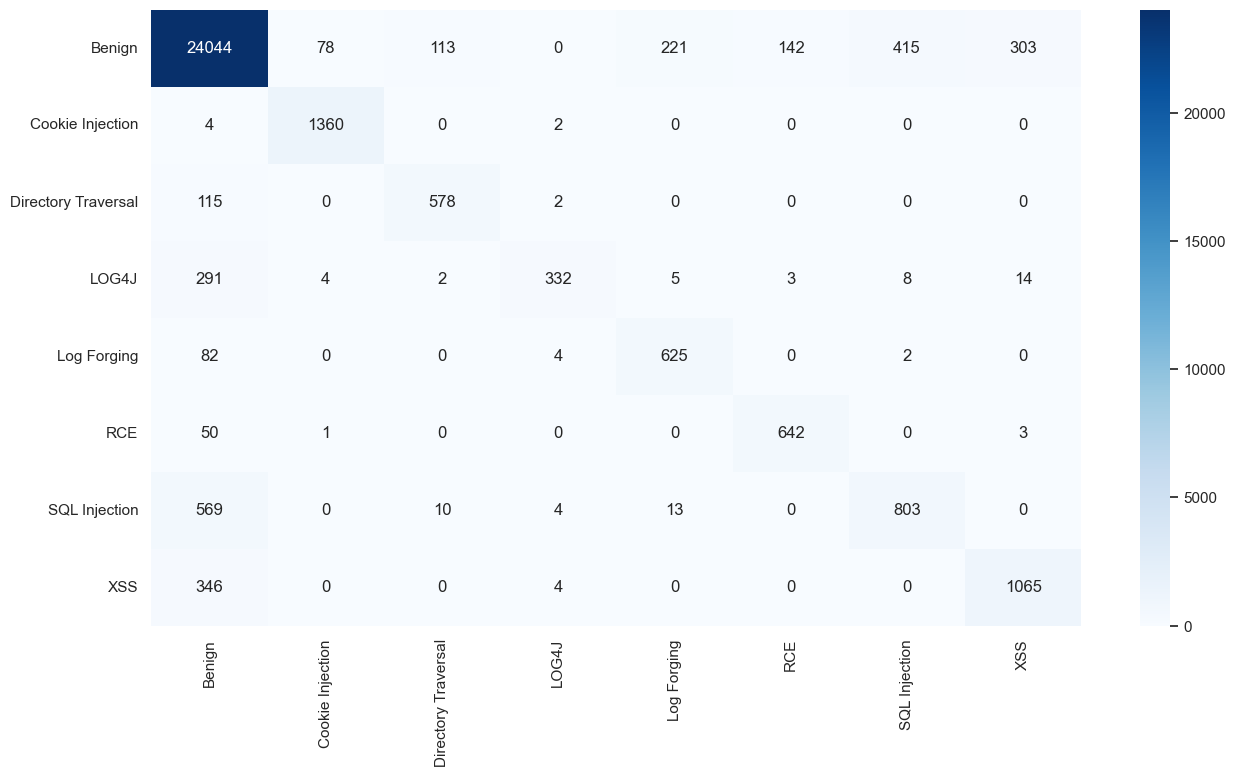

In [81]:

# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = knn.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## Decision Tree

In [90]:

from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 17).fit(X_train, y_train)
print(sorted(Counter(y_train).items()))

[('Benign', 118115), ('Cookie Injection', 6376), ('Directory Traversal', 3244), ('LOG4J', 3074), ('Log Forging', 3324), ('RCE', 3248), ('SQL Injection', 6525), ('XSS', 6602)]


                     precision    recall  f1-score   support

             Benign    0.97015   0.95631   0.96318     25316
   Cookie Injection    0.97776   0.99780   0.98768      1366
Directory Traversal    0.94429   1.00000   0.97135       695
              LOG4J    0.89916   0.48710   0.63189       659
        Log Forging    0.72377   0.94811   0.82089       713
                RCE    1.00000   1.00000   1.00000       696
      SQL Injection    0.77230   0.82916   0.79972      1399
                XSS    0.72878   0.86784   0.79226      1415

           accuracy                        0.94079     32259
          macro avg    0.87703   0.88579   0.87087     32259
       weighted avg    0.94449   0.94079   0.94069     32259



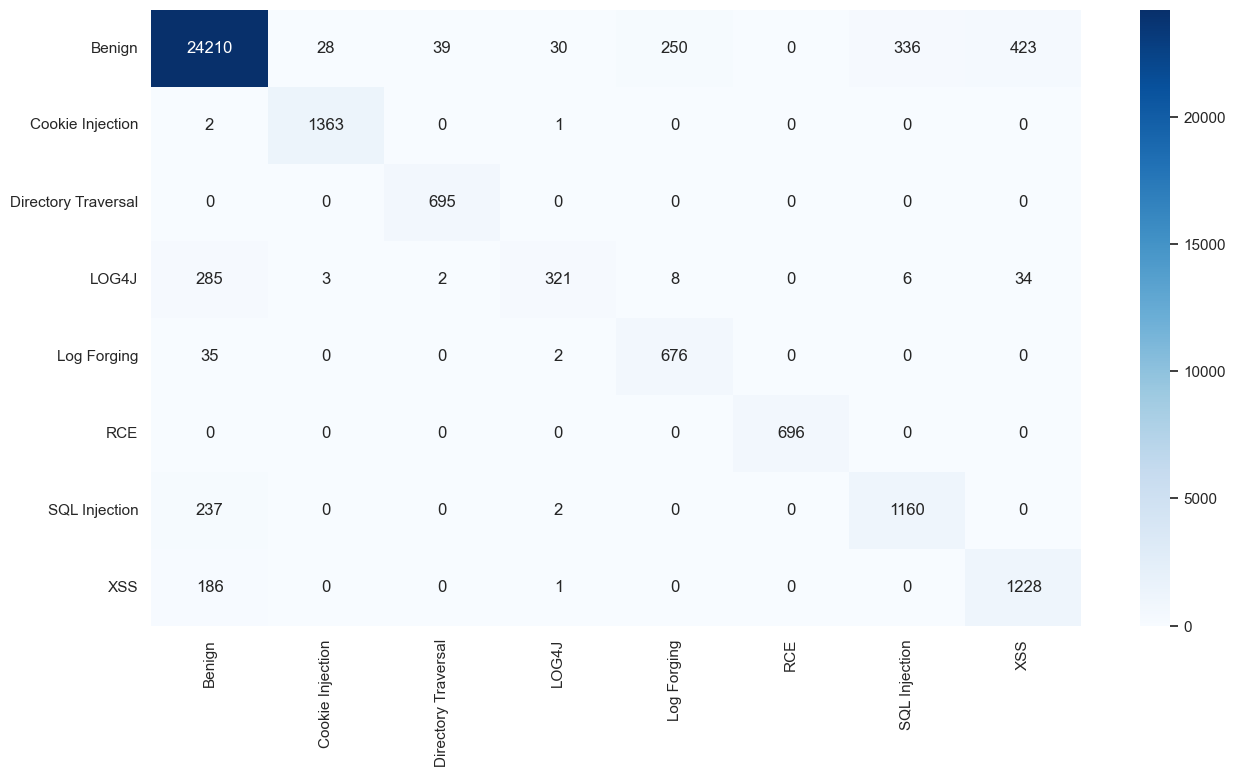

In [91]:

sns.set(rc={'figure.figsize':(15,8)})
dtree_predictions = dtree_model.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, dtree_predictions)
lc_report = classification_report(true_labels, dtree_predictions, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## Ridge

In [92]:
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier(alpha=0.5).fit(X_train, y_train)
print(sorted(Counter(y_train).items()))

[('Benign', 118115), ('Cookie Injection', 6376), ('Directory Traversal', 3244), ('LOG4J', 3074), ('Log Forging', 3324), ('RCE', 3248), ('SQL Injection', 6525), ('XSS', 6602)]


C:\Users\Public\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Public\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Public\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

             Benign    0.80645   1.00000   0.89285     25316
   Cookie Injection    1.00000   0.50366   0.66991      1366
Directory Traversal    0.00000   0.00000   0.00000       695
              LOG4J    0.97207   0.26404   0.41527       659
        Log Forging    0.00000   0.00000   0.00000       713
                RCE    0.00000   0.00000   0.00000       696
      SQL Injection    0.00000   0.00000   0.00000      1399
                XSS    0.00000   0.00000   0.00000      1415

           accuracy                        0.81149     32259
          macro avg    0.34731   0.22096   0.24726     32259
       weighted avg    0.69508   0.81149   0.73754     32259



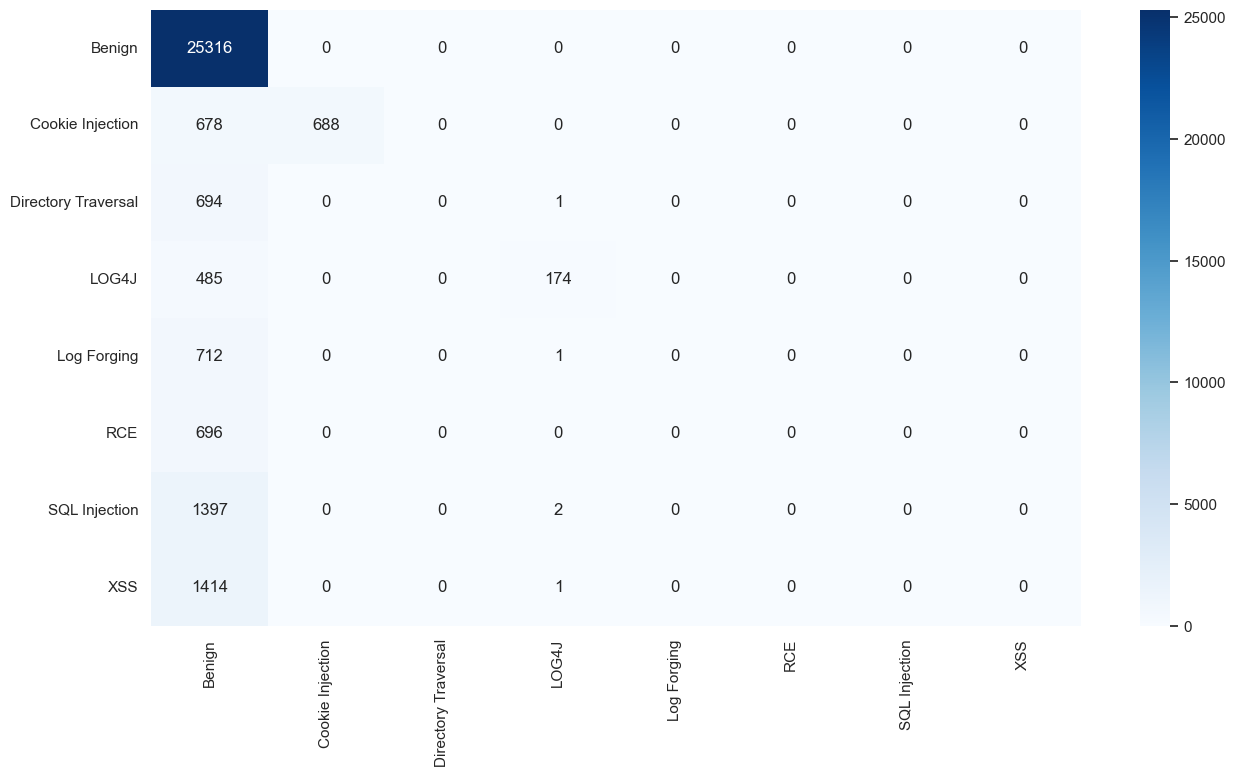

In [93]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = ridge.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## Ada boost

In [95]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=660)
ada.fit(X_train, y_train)

# bdt_real = AdaBoostClassifier(
#     DecisionTreeClassifier(max_depth=2), n_estimators=300, learning_rate=1
# )

# bdt_discrete = AdaBoostClassifier(
#     DecisionTreeClassifier(max_depth=2),
#     n_estimators=300,
#     learning_rate=1.5,
#     algorithm="SAMME",
# )

# bdt_real.fit(X_train, y_train)
# bdt_discrete.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 118115), ('Cookie Injection', 6376), ('Directory Traversal', 3244), ('LOG4J', 3074), ('Log Forging', 3324), ('RCE', 3248), ('SQL Injection', 6525), ('XSS', 6602)]


C:\Users\Public\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Public\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Public\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

             Benign    0.80188   1.00000   0.89005     25316
   Cookie Injection    1.00000   0.50366   0.66991      1366
Directory Traversal    0.00000   0.00000   0.00000       695
              LOG4J    0.00000   0.00000   0.00000       659
        Log Forging    0.00000   0.00000   0.00000       713
                RCE    0.00000   0.00000   0.00000       696
      SQL Injection    0.00000   0.00000   0.00000      1399
                XSS    0.00000   0.00000   0.00000      1415

           accuracy                        0.80610     32259
          macro avg    0.22523   0.18796   0.19499     32259
       weighted avg    0.67163   0.80610   0.72685     32259



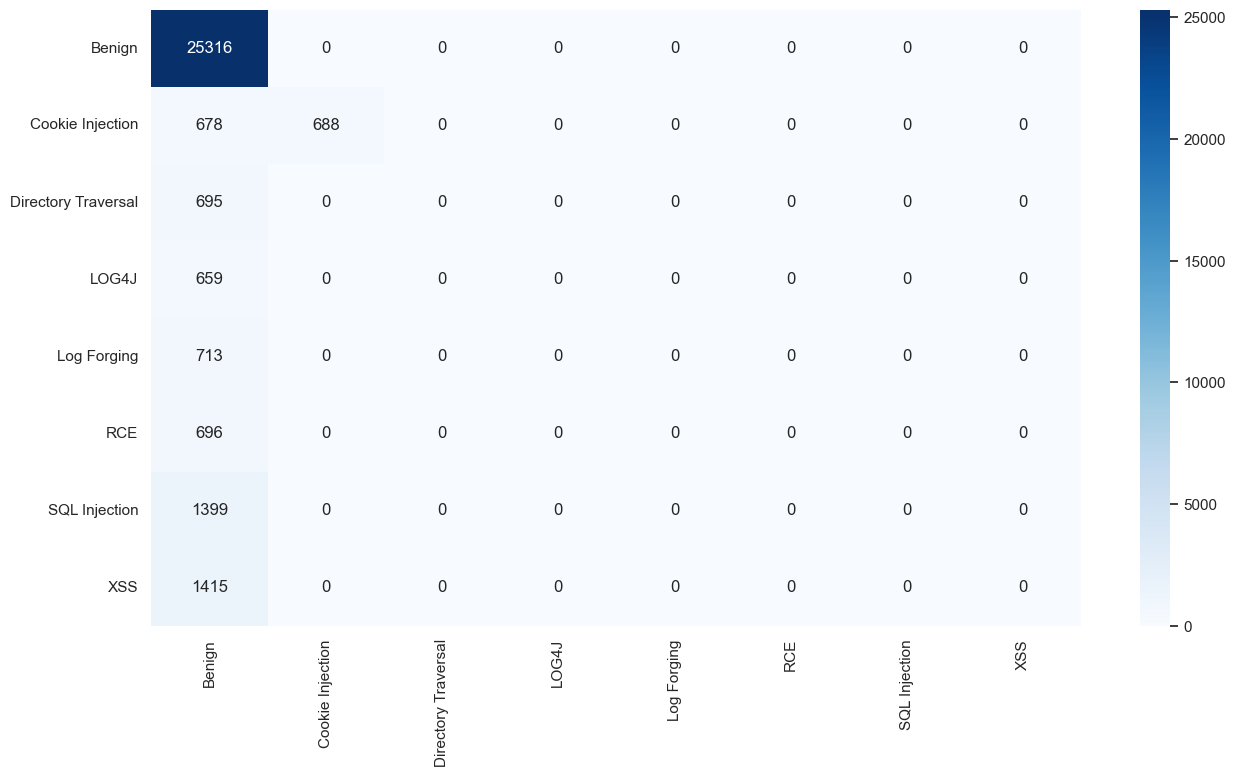

In [96]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = ada.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## Stacking

In [97]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators = [('Decision Tree', dtree_model), ('Random forest', clf)],
                            n_jobs = -1) 
stack.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 118115), ('Cookie Injection', 6376), ('Directory Traversal', 3244), ('LOG4J', 3074), ('Log Forging', 3324), ('RCE', 3248), ('SQL Injection', 6525), ('XSS', 6602)]


C:\Users\Public\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                     precision    recall  f1-score   support

             Benign    0.96197   0.96433   0.96315     25316
   Cookie Injection    0.97842   0.99561   0.98694      1366
Directory Traversal    0.94422   0.99856   0.97063       695
              LOG4J    0.93084   0.49014   0.64215       659
        Log Forging    0.76440   0.81907   0.79079       713
                RCE    1.00000   1.00000   1.00000       696
      SQL Injection    0.80466   0.76555   0.78462      1399
                XSS    0.73980   0.84594   0.78932      1415

           accuracy                        0.94045     32259
          macro avg    0.89054   0.85990   0.86595     32259
       weighted avg    0.94154   0.94045   0.93938     32259



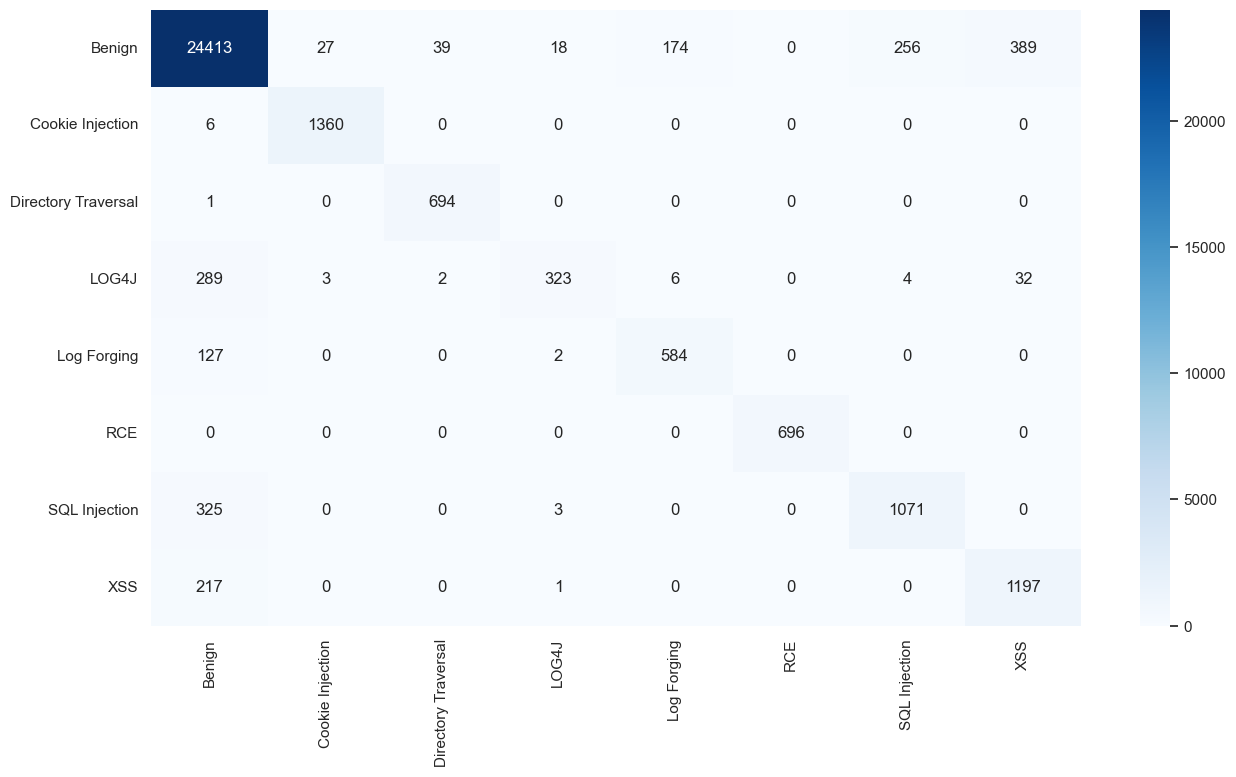

In [98]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = stack.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## hard voting

In [99]:

from sklearn.ensemble import VotingClassifier

vot = VotingClassifier(estimators = [('Decision Tree', dtree_model), ('Random forest', clf)], voting='hard')
vot.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 118115), ('Cookie Injection', 6376), ('Directory Traversal', 3244), ('LOG4J', 3074), ('Log Forging', 3324), ('RCE', 3248), ('SQL Injection', 6525), ('XSS', 6602)]


                     precision    recall  f1-score   support

             Benign    0.95108   0.97061   0.96074     25316
   Cookie Injection    0.97765   0.99268   0.98511      1366
Directory Traversal    0.94437   0.97698   0.96040       695
              LOG4J    0.87738   0.48862   0.62768       659
        Log Forging    0.73995   0.82609   0.78065       713
                RCE    1.00000   0.99856   0.99928       696
      SQL Injection    0.82609   0.70622   0.76146      1399
                XSS    0.79177   0.70671   0.74683      1415

           accuracy                        0.93620     32259
          macro avg    0.88853   0.83331   0.85277     32259
       weighted avg    0.93453   0.93620   0.93379     32259



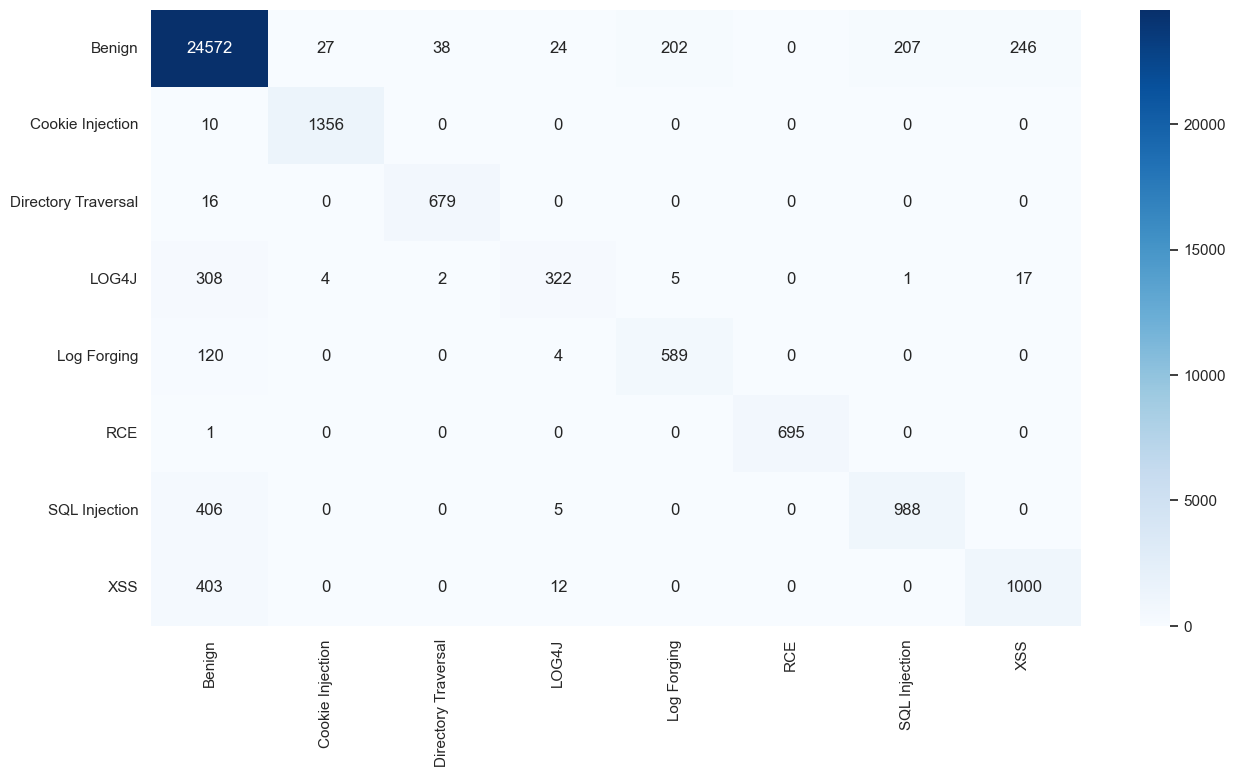

In [100]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = vot.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

## soft voting

In [101]:
vot_soft = VotingClassifier(estimators = [('Decision Tree', dtree_model), ('Random forest', clf)], voting='soft')
vot_soft.fit(X_train, y_train)
# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 118115), ('Cookie Injection', 6376), ('Directory Traversal', 3244), ('LOG4J', 3074), ('Log Forging', 3324), ('RCE', 3248), ('SQL Injection', 6525), ('XSS', 6602)]


                     precision    recall  f1-score   support

             Benign    0.96140   0.96220   0.96180     25316
   Cookie Injection    0.97776   0.99780   0.98768      1366
Directory Traversal    0.94429   1.00000   0.97135       695
              LOG4J    0.88705   0.48862   0.63014       659
        Log Forging    0.72371   0.90743   0.80523       713
                RCE    1.00000   1.00000   1.00000       696
      SQL Injection    0.78444   0.78556   0.78500      1399
                XSS    0.75869   0.77102   0.76481      1415

           accuracy                        0.93840     32259
          macro avg    0.87967   0.86408   0.86325     32259
       weighted avg    0.93922   0.93840   0.93738     32259



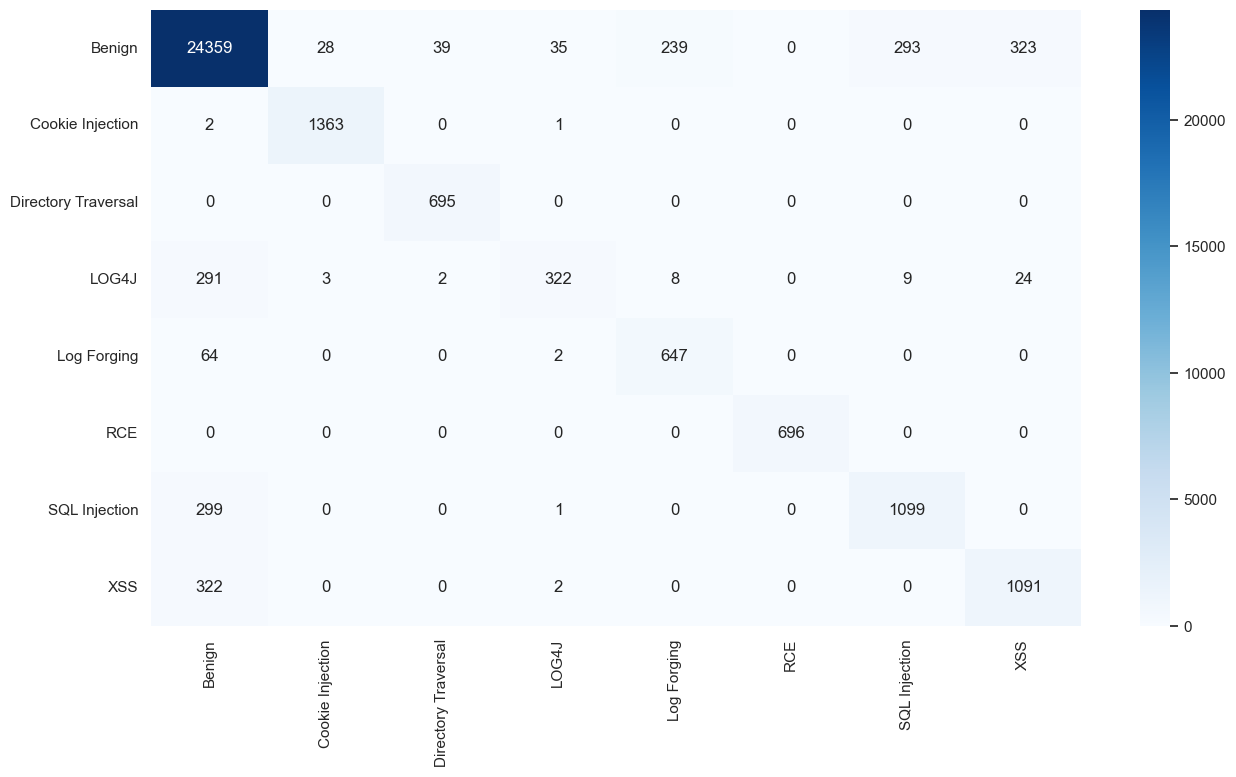

In [102]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
prediction = vot_soft.predict(X_test)
true_labels = y_test
lc_matrix = confusion_matrix(true_labels, prediction)
lc_report = classification_report(true_labels, prediction, digits=5)
heatmap = sns.heatmap(lc_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(lc_report)

# Validation

In [103]:

with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,?1,"en-US,en;q=0.5",none,websocket,max-age=0,?1,document,['ck=WP4apE8KHQSTZBX9kx7cvWTrThwDMKlybR7wL3EwN...,"Sun, 18 Dec 2022 01:22:25 GMT",GET,http://127.0.0.1:5000/forum,,200 OK,text/html; charset=utf-8,52580,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,max-age=0,?1,document,['cid=Cziiu8ULTeufPE1g40GeQaOFYcIZVLiB0LjWDqoO...,"Sun, 18 Dec 2022 01:49:44 GMT",POST,http://127.0.0.1:5000/forgot-password,okS0GXYRSP9ABddqnOgM,200 OK,application/json,141,200,"{""message"": ""Reset link was sent to this email...","""Windows""",20,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,de-CH,none,same-origin,no-store,?1,document,['ck=7OXWoFbHDNCZlNlDOajc02zVRzo_esFhpAt_JnhZj...,"Sun, 18 Dec 2022 01:21:28 GMT",POST,http://127.0.0.1:5000/categories/check/all?fil...,ShmMK0HcQijBloDhmeO6,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...","""Windows""",20,NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,max-age=0,?1,document,['cid=WlkCQThBcDH7JqJsUSX661fQKcW_3Drc65yKTqbm...,"Sun, 18 Dec 2022 01:39:51 GMT",GET,http://127.0.0.1:5000/?id=9263979.549875157&re...,,200 OK,text/html; charset=utf-8,34,200,text/html; charset=utf-8,"""Windows""",NaN,NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,?0,"en-US,en;q=0.5",none,websocket,no-store,?1,document,['ttauth=mMuAu2YMwZNIDKhH1Pcifat1GJ56PBUhi4goh...,"Sun, 18 Dec 2022 01:24:29 GMT",GET,http://127.0.0.1:5000/about/greet?resource=PWw...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,"""Windows""",NaN,NaN,NaN,NaN,NaN


In [104]:

# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,?1,"en-US,en;q=0.5",none,websocket,max-age=0,?1,document,['ck=WP4apE8KHQSTZBX9kx7cvWTrThwDMKlybR7wL3EwN...,"Sun, 18 Dec 2022 01:22:25 GMT",GET,http://127.0.0.1:5000/forum,,200 OK,text/html; charset=utf-8,52580,200,text/html; charset=utf-8,None,None,None,None,None,None
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,max-age=0,?1,document,['cid=Cziiu8ULTeufPE1g40GeQaOFYcIZVLiB0LjWDqoO...,"Sun, 18 Dec 2022 01:49:44 GMT",POST,http://127.0.0.1:5000/forgot-password,okS0GXYRSP9ABddqnOgM,200 OK,application/json,141,200,"{""message"": ""Reset link was sent to this email...","""Windows""",20,None,None,None,None
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,de-CH,none,same-origin,no-store,?1,document,['ck=7OXWoFbHDNCZlNlDOajc02zVRzo_esFhpAt_JnhZj...,"Sun, 18 Dec 2022 01:21:28 GMT",POST,http://127.0.0.1:5000/categories/check/all?fil...,ShmMK0HcQijBloDhmeO6,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...","""Windows""",20,None,None,None,None
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"x-gzip, x-deflate, gzip, deflate",*/*,keep-alive,?1,"en-US,en;q=0.9,he;q=0.8",none,websocket,max-age=0,?1,document,['cid=WlkCQThBcDH7JqJsUSX661fQKcW_3Drc65yKTqbm...,"Sun, 18 Dec 2022 01:39:51 GMT",GET,http://127.0.0.1:5000/?id=9263979.549875157&re...,,200 OK,text/html; charset=utf-8,34,200,text/html; charset=utf-8,"""Windows""",None,None,None,None,None
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,?0,"en-US,en;q=0.5",none,websocket,no-store,?1,document,['ttauth=mMuAu2YMwZNIDKhH1Pcifat1GJ56PBUhi4goh...,"Sun, 18 Dec 2022 01:24:29 GMT",GET,http://127.0.0.1:5000/about/greet?resource=PWw...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,"""Windows""",None,None,None,None,None


In [105]:
df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Sec-Ch-Ua-Mobile,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Cache-Control,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.status_code,response.body,request.headers.Sec-Ch-Ua-Platform,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,request.headers.Upgrade-Insecure-Requests
0,0,0.000000,1,0,0,0.0,3,1,2,0.0,0,1,-0.095346,0,0.000000,0,-0.408248,200,-0.408248,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.182574,1,0,0,0.0,4,1,2,0.0,0,1,0.449977,1,0.000000,0,0.000000,200,0.816497,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.577350,105,0,0,0.0,2,1,1,0.0,0,1,0.778499,1,0.000000,0,0.000000,200,-0.872872,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.000000,105,0,0,0.0,4,1,2,0.0,0,1,0.608581,0,-0.816497,0,-0.408248,200,-0.408248,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.894427,1,0,0,0.0,3,1,2,0.0,0,1,0.273576,0,0.408248,0,-0.408248,200,-0.408248,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
#drops

In [107]:
val = df[features_list].to_numpy()

sns.set(rc={'figure.figsize':(15,8)})
prediction = dtree_model.predict(val)
print(prediction)

['Benign' 'Benign' 'Benign' ... 'LOG4J' 'SQL Injection' 'LOG4J']


In [108]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(prediction), fmt='%2d')